In [26]:
import torch
from torch import nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

In [38]:
class NeuralODE(nn.Module):
    def __init__(self,nin, nout,layers):
        super(NeuralODE,self).__init__()
        m_layers = []
        m_layers.append(nn.Linear(nin,layers[0]))
        print(f'[{nin},{layers[0]}]')
        m_layers.append(nn.SiLU())
        for i in range(len(layers)-1):
            m_layers.append(nn.Linear(layers[i],layers[i+1]))
            print(f'[{layers[i]},{layers[i+1]}]')
            m_layers.append(nn.SiLU())
        m_layers.append(nn.Linear(layers[-1],nout))
        print(f'[{layers[-1]},{nout}]')
        self.network=nn.Sequential(*m_layers)

    def forward(self, y0, tsteps):
        

        return odeint(self.odefunc,tsteps,y0) # [nt,2]
        
    
    def odefunc(self,t,y): #output dy/dt
        return self.network(y)


In [28]:
class NeuralODEClass(nn.Module):

    def __init__(self, nin, nhidden):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(nin, nhidden),
            nn.SiLU(),  # Tanh is not the best
            nn.Linear(nhidden, nhidden),
            nn.SiLU(),
            nn.Linear(nhidden, nin)
        )

    def odefunc(self, t, y):  # provide dy/dt = f(t, y)
        return self.network(y)

    def forward(self, y0, tsteps):
        yhat = odeint(self.odefunc, y0, tsteps)
        return yhat

In [29]:
def train(y_train,t_train,model, optimizer, lossfn):

    model.train()
    optimizer.zero_grad()
    yhat = model(y_train[0, :], t_train)
    loss = lossfn(yhat,y_train)
    loss.backward()
    optimizer.step()
    
    return loss.item()


In [30]:
def train2(y_train, t_train, model, optimizer, lossfn):

    model.train()
    optimizer.zero_grad()
    yhat = model(y_train[0, :], t_train)
    loss = lossfn(yhat, y_train)
    loss.backward()
    optimizer.step()

    return loss.item()

In [39]:
data = np.loadtxt('in_class.txt')
t_train = torch.tensor(data[:,0],dtype=torch.float32) #[nt,]
y_train = torch.tensor(data[:,1:],dtype=torch.float32) #[nt,2]
print(t_train.shape)
print(y_train.shape)

torch.Size([1000])
torch.Size([1000, 2])


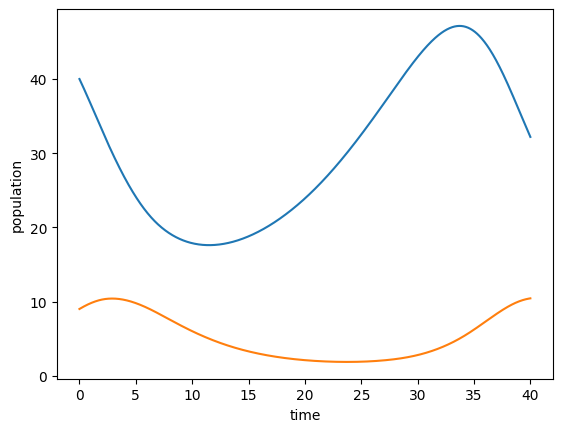

In [40]:
plt.figure()
plt.plot(t_train,y_train[:,0])
plt.plot(t_train,y_train[:,1])
plt.xlabel('time')
plt.ylabel('population')
plt.show()

In [41]:
    
model = NeuralODE(2,1,[10,15,12])#.float()
model2 = NeuralODEClass(nin=2, nhidden=24).double()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(),lr=1e-3)
lossfn = nn.MSELoss()



[2,10]
[10,15]
[15,12]
[12,1]


In [45]:
print(t_train.shape)
y0 = y_train[0,:] # initial condition is first point
print(y0.shape)
yhat = model.forward(y0,t_train)
model.eval()
print(yhat.shape)

torch.Size([1000])
torch.Size([2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 2x10)